In [1]:
import pandas as pd
import os
import torch
import transformers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
#matplotlib.rcParams['pdf.fonttype'] = 42
#matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
#matplotlib.rcParams['ps.useafm'] = True
#matplotlib.rcParams['pdf.use14corefonts'] = True
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.usetex'] = True
device = 'cuda:0'
blue_map = plt.get_cmap('Blues')
red_map = plt.get_cmap('Oranges')
green_map = plt.get_cmap('Greens')
from pathlib import Path
fpath = Path(matplotlib.get_data_path(), "/mnt/storage1/fonts_docker/edukai-4.0.ttf")
prop = matplotlib.font_manager.FontProperties(fname=fpath, size=20)

In [7]:
result = '/mnt/storage3/ship_backup_emnlp/groups/result_summary/'
shift = '1000'
#task = ['CoLA', 'RTE', 'STS-B', 'MRPC', 'SST-2', 'QQP', 'QNLI', 'MNLI']
task = ['MNLI', 'QQP', 'QNLI', 'SST-2', 'CoLA', 'STS-B', 'MRPC', 'RTE']
#metric = ['eval_mcc', 'eval_acc', 'eval_spearmanr', 'eval_f1', 'eval_acc', 
#          'eval_f1', 'eval_acc', 'eval_mnli/acc']
metric = ['eval_mnli/acc', 'eval_f1', 'eval_acc', 'eval_acc', 'eval_mcc', 
          'eval_spearmanr', 'eval_f1', 'eval_acc']
#metric = ['training_mcc', 'training_acc', 'training_spearmanr', 'training_f1', 
#          'training_acc', 'training_f1', 'training_acc', 'training_mnli/acc']
#step = ['scratch', 'pretrain20k', 'pretrain200k', 
#        'pretrain500k', 'pretrain1M', 'pretrain']
#step = ['scratch', 'pretrain1M']
step = ['scratch_albert_base_v1', 'pretrain_albert20k', 'pretrain_albert200k', 
        'pretrain_albert500k', 'pretrain_albert1M', 'pretrain_albert_v1']
#step = ['pretrain', 'pretrain_roberta_base', 'pretrain_albert_base_v1', 
#        'pretrain_bert_large', 'scratch', 'scratch_bert_large', 'scratch_albert_base_v1']
#step = ['scratch_albert_base_v1']
def get_acc(shift, step, prefix = '', scratch_prefix = ''):
    task_acc = {}
    task_std = {}
    task_origin_acc = {}
    for t in task:
        task_acc[t] = []
        task_std[t] = []
        task_origin_acc[t] = []
    for i, t in enumerate(task):
        '''
        if scratch:
            csv = pd.read_csv(os.path.join(result, t, shift, f'scratch{scratch_prefix}', 'summary.csv'), 
                                  engine='python', 
                                  index_col=0)
            mean = csv['mean'][metric[i]]
            std = csv['stddev'][metric[i]]
            task_acc[t].append(mean)
            task_std[t].append(std)
        '''
        
        for s in step:
            
            try:
                csv = pd.read_csv(os.path.join(result, t, shift, f'{prefix}{s}', 'summary.csv'), 
                                  engine='python', 
                                  index_col=0)
            except:
                if s == '':
                    csv = pd.read_csv(os.path.join(result, t, shift, 'pretrain_normal', 'summary.csv'), 
                                      engine='python', 
                                      index_col=0)
                else:
                    continue
            mean = csv['mean'][metric[i]]
            std = csv['stddev'][metric[i]]
            #if t == 'QQP' and s == 'pretrain500k':
            #    task_origin_acc[t].append([csv['rand100'][metric[i]], qqp_missing_f1, csv['rand102'][metric[i]]])
                #print(task_origin_acc[t][-1])
            #else:
            #print(s,t)
            task_origin_acc[t].append([csv['rand100'][metric[i]], csv['rand101'][metric[i]], csv['rand102'][metric[i]]])
            task_acc[t].append(mean)
            task_std[t].append(std)
    return task_acc, task_std, task_origin_acc
result = '/mnt/storage1/EMNLP2021/thesis/BERT-cross-disciplinary/result_summary/main_exp/GLUE/result_summary/'
task_acc, task_std, task_origin_acc = get_acc('1000', step = step)
step[-1] = 'pretrain_normal'
result = '/mnt/storage3/ship_backup_emnlp/groups/result_summary/' #ALBERT的log分散在各地
normal_acc, normal_std, normal_origin_acc = get_acc('0', step = step)
for k in normal_acc.keys():
    normal_acc[k].insert(0, task_acc[k][0])
    normal_origin_acc[k].insert(0, task_origin_acc[k][0])

def mean_std_glue_acc(acc_dict):
    task_origin_acc_array = np.array([acc_dict[k] for k in acc_dict])
    mean_glue_origin_acc = np.mean(task_origin_acc_array, axis= 0)
    mean_origin_acc = np.mean(mean_glue_origin_acc, axis = -1)
    std_origin_acc = np.std(mean_glue_origin_acc, axis = -1)
    return mean_origin_acc, std_origin_acc

## draw average

/tmp/ipykernel_311/1141660976.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '20k', '200k', '500k', '1M', 'google'], fontsize=16)


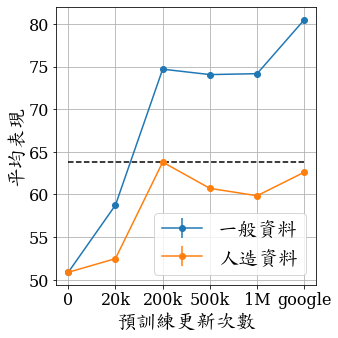

In [8]:
shift_mean, shift_std = mean_std_glue_acc(task_origin_acc)
normal_mean, normal_std = mean_std_glue_acc(normal_origin_acc)

fig, ax = plt.subplots(1,1, figsize = [4.8,4.8])
x = list(range(len(normal_mean)))
#ax.plot(x, np.array(normal_mean)*100, '-o', label = '一般資料')
ax.errorbar(x, np.array(normal_mean)*100, yerr=normal_std*10, fmt='-o', label = '一般資料')
#ax.plot(x, np.array(shift_mean)*100, '-o', label = '人造資料')
ax.errorbar(x, np.array(shift_mean)*100, yerr=shift_std*10, fmt='-o', label = '人造資料')
ax.set_xticklabels(['0', '20k', '200k', '500k', '1M', 'google'], fontsize=16)
ax.set_xticks(x)
#ax.set_ylim(bottom = min(0.5, np.min( task_acc[k]))*100, top=100)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
ax.grid()
#ax.set_title(k, fontsize = 14)

ax.hlines(shift_mean[2]*100, xmin = 0, xmax = len(step)-1, colors = 'black', linestyles = 'dashed')


ax.set_ylabel('平均表現', fontproperties=prop)
ax.set_xlabel('預訓練更新次數', fontproperties=prop)

#fig.show()
#handles, labels = ax.get_legend_handles_labels()
ax.legend(prop=prop)
#fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.tight_layout()
    #break
fig.savefig('../thesis_picture/GLUE_albert_ckpt.pdf')

## draw detail

In [231]:
def mean_std_task(acc_dict):
    task_origin_acc_array = np.array([acc_dict[k] for k in acc_dict])
    mean_task_acc = np.mean(task_origin_acc_array, axis= 2)
    std_task_acc = np.std(task_origin_acc_array, axis = 2)
    return mean_task_acc, std_task_acc

/tmp/ipykernel_5532/1549140197.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,j].set_xticklabels(['0', '20k', '200k', '500k', '1M', 'google'], fontsize=12, rotation = 45)


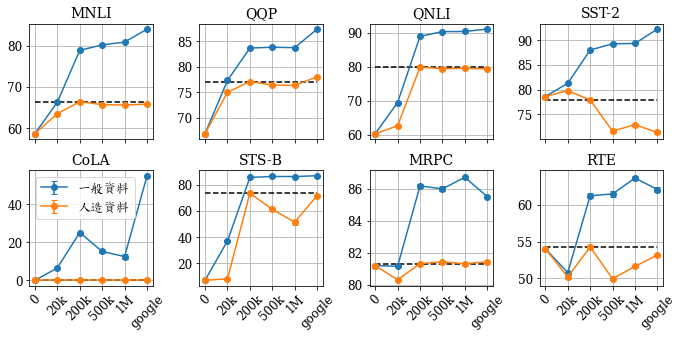

In [233]:
shift_mean, shift_std = mean_std_task(task_origin_acc)
normal_mean, normal_std = mean_std_task(normal_origin_acc)



fig, ax = plt.subplots(2, 4, figsize = [9.6, 4.8], sharex=True, sharey=False)
for n, k in enumerate(range(shift_mean.shape[0])):
    i = n // 4
    j = n % 4
    x = list(range(shift_mean.shape[1]))
    #ax.plot(x, np.array(normal_mean)*100, '-o', label = '一般資料')
    ax[i,j].errorbar(x, np.array(normal_mean[n])*100, yerr=normal_std[n]*10, fmt='-o', label = '一般資料', capsize = 3)
    #ax.plot(x, np.array(shift_mean)*100, '-o', label = '人造資料')
    ax[i,j].errorbar(x, np.array(shift_mean[n])*100, yerr=shift_std[n]*10, fmt='-o', label = '人造資料', capsize = 3)
    ax[i,j].set_xticklabels(['0', '20k', '200k', '500k', '1M', 'google'], fontsize=12, rotation = 45)
    ax[i,j].set_xticks(x)
    #ax.set_ylim(bottom = min(0.5, np.min( task_acc[k]))*100, top=100)
    for tick in ax[i,j].yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    ax[i,j].grid()
    ax[i,j].set_title(task[n], fontsize = 14)

    ax[i,j].hlines(shift_mean[n][2]*100, xmin = 0, xmax = len(step)-1, colors = 'black', linestyles = 'dashed')
    #prop = matplotlib.font_manager.FontProperties(fname=fpath)
    #ax[i,j].legend(prop=prop)
#fig.set_ylabel('平均表現', fontproperties=prop)
#fig.set_xlabel('預訓練更新次數', fontproperties=prop)

#fig.show()
prop = matplotlib.font_manager.FontProperties(fname=fpath, size=13)
ax[1,0].legend(prop=prop)
#handles, labels = ax[0,0].get_legend_handles_labels()
#fig.legend(handles, labels, prop=prop)
#fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.tight_layout()
    #break
fig.savefig('../thesis_picture/GLUE_albert_ckpt_detail.pdf')


## old draw

In [3]:
task_acc, task_std = get_acc('1000', step = step)
step = ['pretrain_normal', 'pretrain_chinese']
normal_acc, normal_std = get_acc('0', step = step)
#for k in normal_acc.keys():
#    normal_acc[k].insert(0, task_acc[k][0])

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = [9.6, 7.2], sharex=True, sharey=True)
width = 0.5
task_step = ['p-bert', 'p-roberta', 'p-albert-v1', 
        'p-bert-L', 's-bert', 's-bert-L', 's-albert-v1']
normal_step = ['p-normal', 'p-bert-chinese']
labels = task_step + normal_step
for n, k in enumerate(normal_acc.keys()):
    i = n // 4
    j = n % 4
    x = np.array(range(len(labels)))
    x1 = x[:len(normal_acc[k])]
    x2 = x[len(normal_acc[k]):]
    
    for ii, m in enumerate(normal_step):
        if m=='p-normal':
            ax[i,j].hlines(normal_acc[k][ii], xmin = 0, xmax = len(labels)-1, colors = 'black', linestyles = 'dashed')
        else:
            ax[i,j].bar(x1[ii-1], normal_acc[k][ii], yerr = normal_std[k][ii], width = width, label = normal_step[ii], capsize = 3)
    for ii, m in enumerate(task_step):
        ax[i,j].bar(x2[ii]-1, task_acc[k][ii], yerr = task_std[k][ii], width = width, label = task_step[ii], capsize = 3)
    #ax[i,j].bar(x2, task_acc[k], yerr = task_std[k], width = width, label = 'shift 1000')
    #ax[i,j].set_xticklabels(labels, rotation = 45)
    ax[i,j].set_xticks(x[:-1])
    ax[i,j].set_ylim(0, 1)
    #ax[i,j].grid()
    ax[i,j].set_title(k, fontsize = 14)
    #ax[i,j].hlines(task_acc[k][1], xmin = 0, xmax = len(step), colors = 'black', linestyles = 'dashed')
fig.show()
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.subplots_adjust(hspace=0.3)
#fig.tight_layout()
    #break
fig.savefig('./images/shift/models.png')

In [ ]:
for k in task_acc.keys():
    print(k)
    print(task_acc[k][2])

<ipython-input-11-832be6d4fcf7>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,j].set_xticklabels(['0', '20k', '200k', '500k', '1M', 'google'], rotation = 45)


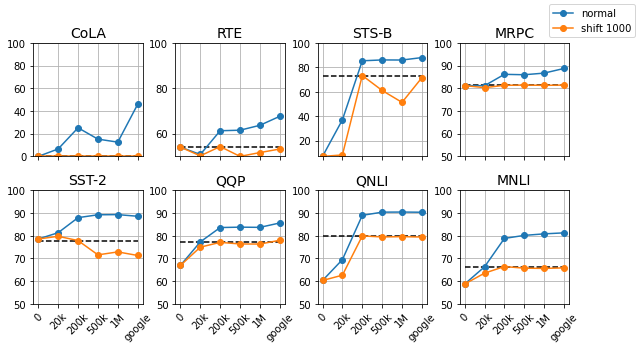

In [11]:
'''
draw multiple step
'''

fig, ax = plt.subplots(2,4, figsize = [9.6, 4.8], sharex=True, sharey=False)
for n, k in enumerate(normal_acc.keys()):
    i = n // 4
    j = n % 4
    x = list(range(len(normal_acc[k])))
    ax[i,j].plot(x, np.array(normal_acc[k])*100, '-o', label = 'normal')
    ax[i,j].plot(x, np.array(task_acc[k])*100, '-o', label = 'shift 1000')
    ax[i,j].set_xticklabels(['0', '20k', '200k', '500k', '1M', 'google'], rotation = 45)
    ax[i,j].set_xticks(x)
    ax[i,j].set_ylim(bottom = min(0.5, np.min( task_acc[k]))*100, top=100)
    ax[i,j].grid()
    ax[i,j].set_title(k, fontsize = 14)
    ax[i,j].hlines(task_acc[k][2]*100, xmin = 0, xmax = len(step)-1, colors = 'black', linestyles = 'dashed')


fig.show()
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.tight_layout()
    #break
fig.savefig('./images/shift_checkpoint/albert_no_WNLI_no_sharey_no_usetex.pdf')


In [15]:
fig.tight_layout()
fig.savefig('./images/shift_checkpoint/bert_no_WNLI_no_sharey_tight.pdf')

In [14]:
for n, k in enumerate(normal_acc.keys()):
    i = n // 4
    j = n % 4
    x = list(range(len(normal_acc[k])))
    ax[i,j].plot(x, np.array(normal_acc[k])*100, '-o', label = 'normal')
    ax[i,j].plot(x, np.array(task_acc[k])*100, '-o', label = 'shift 1000')
    ax[i,j].set_xticklabels(['0', '20k', '200k', '500k', '1M', 'google'], rotation = 45)
    ax[i,j].set_xticks(x)
    ax[i,j].set_ylim(bottom = min(0.5, np.min( task_acc[k]))*100, top=100)
    ax[i,j].grid()
    ax[i,j].set_title(k, fontsize = 14)
    ax[i,j].hlines(task_acc[k][2]*100, xmin = 0, xmax = len(step)-1, colors = 'black', linestyles = 'dashed')
    
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

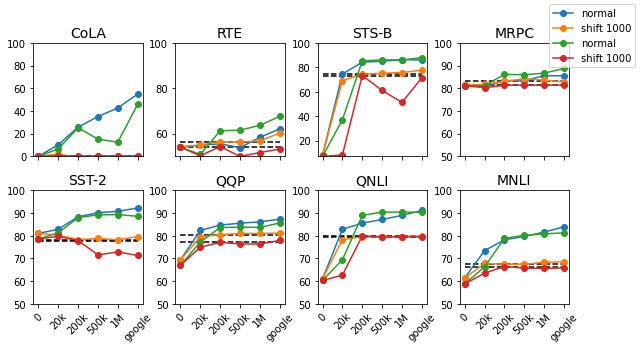

In [15]:
fig

# Draw lipschitz

  0%|          | 0/12 [00:00<?, ?it/s]

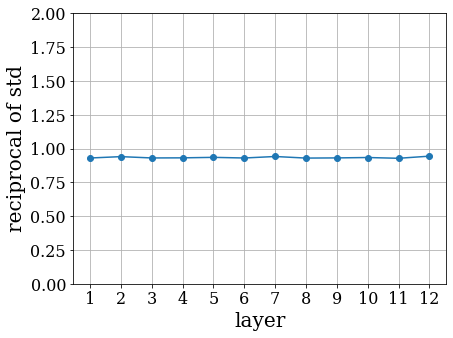

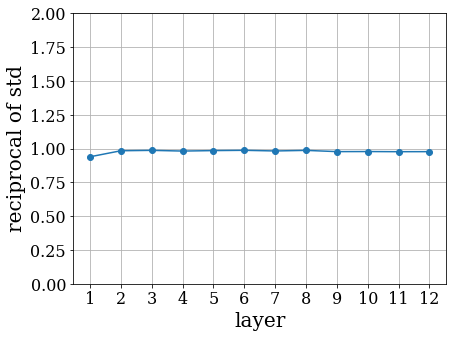

In [4]:
def get_layer_norm(model):
    ffn_layer_norm = []
    attn_layer_norm = []
    for name, param in model.named_parameters():
        if 'LayerNorm' in name and 'attention' in name and 'layer' in name and 'weight' in name:
            attn_layer_norm.append(param.data.unsqueeze(-1))
        elif 'LayerNorm' in name and 'output' in name and 'layer' in name and 'weight' in name:
            ffn_layer_norm.append(param.data.unsqueeze(-1))
    return {'FFN': ffn_layer_norm, 'Attn': attn_layer_norm}


model = ['bert-base-uncased']
task = ['MNLI', 'STS-B', 'SST-2']
correspond_seed = ['100','101','102']
path = './Analysis/lipschitz/'
for m in model:
    config = transformers.AutoConfig.from_pretrained(m)
    for i, t in enumerate(task):
        #for s in correspond_seed:
        fig, ax = plt.subplots(1,1, sharey=True, sharex=True, figsize = [6.4,4.8])
        fig2, ax2 = plt.subplots(1,1, sharey=True, sharex=True, figsize = [6.4,4.8])
        y1 = [torch.load(os.path.join(path, f'pretrain_{m}_shift1000_{t}_rand{s}.pkl')) for s in correspond_seed]
        y2 = [torch.load(os.path.join(path, f'scratch_{m}_shift1000_{t}_rand{s}.pkl')) for s in correspond_seed]
        for j in range(len(correspond_seed)):
            for k in y1[j].keys():
                for pos in y1[j][k].keys():
                    if type(y1[j][k][pos])==list:
                        y1[j][k][pos] = torch.cat(y1[j][k][pos])
        for j in range(len(correspond_seed)):
            for k in y2[j].keys():
                for pos in y1[j][k].keys():
                    if type(y2[j][k][pos])==list:
                        y2[j][k][pos] = torch.cat(y2[j][k][pos])


        ratio_y1 = []
        std_y1 = []
        ratio_y2 = []
        std_y2 = []
        
        for k in tqdm(y1[0].keys()):
            for position in ['FFN', 'Attn']:
                ratio = [(1*( torch.div(1, y2[i][k][position]) )).view(-1) for i in range(len(correspond_seed))]
                ratio = torch.cat(ratio)
                std, ratio = torch.std_mean(ratio)#.item()/ratio.shape[0]
                ratio_y2.append(ratio.item())
                std_y2.append(std.item())
        x=np.array(range( int(len(y1[0].keys())) ))+1
        ax.errorbar(x, ratio_y2[::2], fmt = '-o', yerr = std_y2[::2], label='scratch')
        ax.set_ylim(0, 2)
        ax.grid()
        ax.set_xticks(np.linspace(1, len(x),12))
        ax.set_xticklabels(np.linspace(1, len(x), 12, dtype=int), fontsize=16)
        #ax.set_title(t, fontsize=16)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        prop = matplotlib.font_manager.FontProperties(fname=fpath, size=24)
        #ax.set_xlabel('模型層數', fontproperties=prop)
        #ax.set_ylabel('標準差倒數', fontproperties=prop)
        ax.set_xlabel('layer', fontsize=20)
        ax.set_ylabel('reciprocal of std', fontsize=20)
        ax2.errorbar(x, ratio_y2[1::2], fmt = '-o', yerr = std_y2[1::2], label='scratch')
        ax2.set_ylim(0,2)
        ax2.grid()
        ax2.set_xticks(np.linspace(1, len(x),12))
        ax2.set_xticklabels(np.linspace(1, len(x), 12, dtype=int), fontsize=16)
        #ax2.set_title(t, fontsize=16)
        for tick in ax2.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
            
        prop = matplotlib.font_manager.FontProperties(fname=fpath, size=24)
        #ax2.set_xlabel('模型層數', fontproperties=prop)
        #ax2.set_ylabel('標準差倒數', fontproperties=prop)
        ax2.set_xlabel('layer', fontsize=20)
        ax2.set_ylabel('reciprocal of std', fontsize=20)
        #handles, labels = ax.get_legend_handles_labels()
        #fig.legend(handles, labels)

        #handles, labels = ax2.get_legend_handles_labels()
        #fig2.legend(handles, labels)
        #fig.savefig(f"./images/lipschitz/{m}_MNLI_rand{correspond_seed[i]}.png")
        fig.tight_layout()
        
        fig2.tight_layout()
        #fig.savefig(f"../thesis_picture/lipschitz/scratch_{t}_std_reciprocal_ffn.png")
        #fig2.savefig(f"../thesis_picture/lipschitz/scratch_{t}_std_reciprocal_attn.png")

# Draw dynamical

In [ ]:
import matplotlib
model_list = ['bert-base-uncased', 'albert-base-v1'] # model to run
name = ['BERT', 'ALBERT'] # model name to draw
shift = '1000'
task = 'MNLI SST-2 STS-B' # task to run
data_dir = './shift_1000/' # the 'save_dir' folder of dynamical_isometry.py 


for j, model_name in enumerate(model_list):
    for iii ,task_name in enumerate(task.split(" ")):
        fig, ax = plt.subplots(1, 1, figsize = [6.4, 4.8])
        pre = []
        pre_err = []
        scr = []
        scr_err = []
        now_ax = ax#[0, j]
        pre_sing = torch.load(os.path.join(data_dir, 'pretrain_'+model_name+'_'+task_name+'_shift'+shift+'.pkl'))

        num_token = pre_sing.shape[0]
        pre_sing = pre_sing.view(-1)
        scr_sing = torch.load(os.path.join(data_dir, 'scratch_'+model_name+'_'+task_name+'_shift'+shift+'.pkl'))
        scr_sing = scr_sing.view(-1)

        pre_std, pre_l1_diff = torch.std_mean(torch.abs(pre_sing ))#.item()#/num_token
        scr_std, scr_l1_diff = torch.std_mean(torch.abs(scr_sing ))#.item()#/num_token


        pre.append(pre_l1_diff.item())
        scr.append(scr_l1_diff.item())
        pre_err.append(pre_std.item())
        scr_err.append(scr_std.item())
        now_ax.hist([np.log(pre_sing.numpy()),np.log(scr_sing.numpy())], bins=200, density=True, 
                    label=[name[j], 'scratch'])
        x = np.array(range(len(pre)))+1
        width = 0.2
        plt.axhline(y=0, color='k', linestyle='--')
        box = ax.get_position()
        now_ax.set_position([box.x0, box.y0, box.width, box.height])
        now_ax.legend(fontsize=20)
        #now_ax.set_xticklabels(task.split(' '), fontsize = 16)
        #ax.set_xlabel('對數奇異值', fontproperties=prop)
        ax.set_xlabel('log singular value', fontsize = 20)
        #ax.set_ylabel('機率密度', fontproperties=prop)
        ax.set_ylabel('probability density', fontsize = 20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(16) 
        fig.tight_layout()
        fig.savefig(f'./dynamical/image/{model_name}_{task_name}_shift{shift}_log.png')

# Draw perturbation

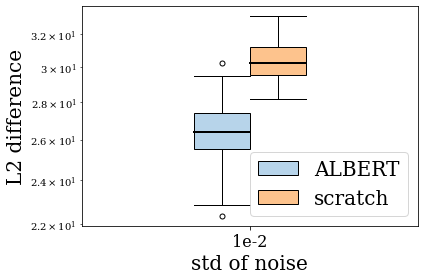

In [11]:
import torch
model_name='albert-base-v1'
task_name='MNLI'
seeds=['100', '101', '102'] # random seed used by perturbation.py
data_dir = './Analysis/perturbation/shift_1000_thesis/' # save_dir folder of perturbation.py
shift='1000' 
task=['MNLI', 'SST-2', 'STS-B'] # task to use
stds = ['0.01', '0.0001', '1e-06', '1e-08'] # std to use
std_value = ['1e-2', '1e-4', '1e-6', '1e-8'] # std name to draw
blue_map = plt.get_cmap('Blues')
red_map = plt.get_cmap('Oranges')
green_map = plt.get_cmap('Greens')
pre_colors = [blue_map(0.3) for i in range(4)]
scr_colors = [red_map(0.3) for i in range(4)]

for task_name in task:
    total = []
    pres = []
    scrs = []
    for std in stds:
        pre = []
        scr = []
        for seed in seeds:
            try:
                scr_diff = torch.load(os.path.join(data_dir, 'scratch_'+model_name+'_shift'+shift+'_std'+std+'_'+task_name+'_rand'+seed+'.pkl')) 
            except:
                scr_diff = torch.load(os.path.join(data_dir, 'scratch_'+model_name+'_shift'+shift+'_std'+str(std_value)+'_'+task_name+'_rand'+seed+'.pkl')) 
            scr_diff = torch.cat(scr_diff)

            try:
                pre_diff = torch.load(os.path.join(data_dir, 'pretrain_'+model_name+'_shift'+shift+'_std'+std+'_'+task_name+'_rand'+seed+'.pkl'))
            except:
                pre_diff = torch.load(os.path.join(data_dir, 'pretrain_'+model_name+'_shift'+shift+'_std'+str(std_value)+'_'+task_name+'_rand'+seed+'.pkl'))

            pre_diff = torch.cat(pre_diff)
            pre.append(pre_diff)
            scr.append(scr_diff)
        pre = torch.cat(pre)
        scr = torch.cat(scr)
        pres.append(pre.numpy())
        scrs.append(scr.numpy())
    fig, (ax) = plt.subplots(1, 1, sharex=True)
    #ax.boxplot([pre,scr], positions=)
    x = np.array(range(len(stds)))+1
    flierprops = {'markersize':5}
    bp1 = ax.boxplot(pres, positions=x-0.1, widths=0.2, patch_artist=True, flierprops=flierprops)
    for i, box in enumerate(bp1['boxes']):
        plt.setp(box, color=pre_colors[i], ec='black')
    for i, med in enumerate(bp1['medians']):
        plt.setp(med, color='black', lw=2.0)
    for i, me in enumerate(bp1['means']):
        plt.setp(me, lw=2.0)
    for i, cap in enumerate(bp1['caps']):
        plt.setp(cap, xdata=cap.get_xdata() + (-0.05,+0.05))
    bp2 = ax.boxplot(scrs, positions=x+0.1, widths=0.2, patch_artist=True, flierprops=flierprops)
    for i, box in enumerate(bp2['boxes']):
        plt.setp(box, color=scr_colors[i], ec='black')
    for i, med in enumerate(bp2['medians']):
        plt.setp(med, color='black', lw=2.0)
    for i, me in enumerate(bp2['means']):
        plt.setp(me, lw=2.0)
    for i, cap in enumerate(bp2['caps']):
        plt.setp(cap, xdata=cap.get_xdata() + (-0.05,+0.05))
    ax.set_xticks(x)
    #ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['預訓練', '從頭訓練'], prop=prop)
    ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['ALBERT', 'scratch'], fontsize=20)
    ax.set_xticklabels(std_value)
    prop = matplotlib.font_manager.FontProperties(fname=fpath, size=20)
    #ax.set_xlabel('加入雜訊之標準差', fontproperties=prop)
    ax.set_xlabel('std of noise', fontsize=20)
    #ax.set_ylabel('L2距離', fontproperties=prop)
    ax.set_ylabel('L2 difference', fontsize=20)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    fig.tight_layout()
    fig.savefig(f'../thesis_picture/perturbation/{model_name}_{task_name}_shift1000_perturbation_no_dropout.png')




# Draw gradient confusion

"\ncolors = ['C0', 'C1']\nbcolors = ['white', 'white']\nfor i, bplot in enumerate(bplot1, bplot2):\n    for patch in bplot['boxes']:\n        patch.set_facecolor('white')\n    for patch in bplot['whiskers']:\n"

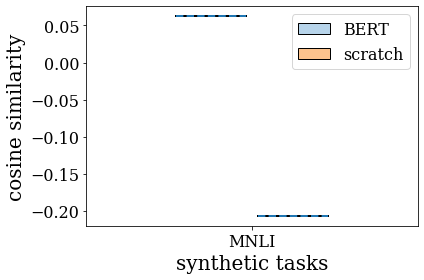

In [8]:
model = 'bert-base-uncased'
task = ['MNLI', 'SST-2', 'STS-B']
mode = 'cosine'
shift = '1000'
pre_list = []
scr_list = []
width = 0.28
pre_pos = np.array(range(len(task))) + 1 - (width + 0.05)/2
scr_pos = np.array(range(len(task))) + 1 + (width + 0.05)/2
fig, ax = plt.subplots()
blue_map = plt.get_cmap('Blues')
red_map = plt.get_cmap('Oranges')
green_map = plt.get_cmap('Greens')
pre_colors = [blue_map(0.3) for i in range(3)]
scr_colors = [red_map(0.3) for i in range(3)]
seeds=[100, 101, 102]
root = f'./Analysis/grad_conf_new/{mode}_shift{shift}'
for t in task:
    task_pre_list = []
    task_scr_list = []
    for seed in seeds:
        path1 = os.path.join(root, f'{mode}_{model}_pretrain_shift{shift}_{t}_rand{seed}.pkl')
        path2 = os.path.join(root, f'{mode}_{model}_scratch_shift{shift}_{t}_rand{seed}.pkl')
        task_pre_list.append(np.array(torch.load(path1)))
        task_scr_list.append(np.array(torch.load(path2)))
    task_pre_list = np.concatenate(task_pre_list)
    task_scr_list = np.concatenate(task_scr_list)
    pre_list.append(task_pre_list)
    scr_list.append(task_scr_list)
bplot1 = ax.boxplot(pre_list, 
                    positions=pre_pos, 
                    widths=width, 
                    whis = (0, 100), 
                    meanline=True, 
                    showmeans=True,
                    patch_artist=True,
                    notch=False,
                    medianprops=dict(color="black", lw=2),
                    meanprops=dict(color="C0", lw=2),
                    boxprops=dict(facecolor=pre_colors[0]))
'''
for i, box in enumerate(bp1['boxes']):
    plt.setp(box, color=pre_colors[i], ec='black')
for i, med in enumerate(bp1['medians']):
    plt.setp(med, color='black', lw=2.0)
for i, me in enumerate(bp1['means']):
    plt.setp(me, lw=2.0)
for i, cap in enumerate(bp1['caps']):
    plt.setp(cap, xdata=cap.get_xdata() + (-0.05,+0.05))
'''
bplot2 = ax.boxplot(scr_list, 
                    positions=scr_pos, 
                    widths=width, 
                    whis = (0, 100), 
                    meanline=True, 
                    showmeans=True,
                    patch_artist=True,
                    notch=False,
                    medianprops=dict(color="black", lw=2),
                    meanprops=dict(color="C0", lw=2),
                    boxprops=dict(facecolor=scr_colors[0]))
ax.set_xticks([1,2,3])
ax.set_xticklabels([t for t in task])
#ax.set_xticklabels([t+'_p' for t in task]+[t+'_s' for t in task])
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
#from pathlib import Path
#fpath = Path(matplotlib.get_data_path(), "/usr/share/fonts/truetype/edukai-4.0.ttf")
prop = matplotlib.font_manager.FontProperties(fname=fpath, size=16)
#ax.legend([bplot1["boxes"][0], bplot2["boxes"][0]], 
#         ["預訓練", "從頭訓練"], fontsize=16, prop=prop)
ax.legend([bplot1["boxes"][0], bplot2["boxes"][0]], 
         ["BERT", "scratch"], fontsize=16)
#ax.set_xlabel('人造資料任務', fontproperties=prop)
#ax.set_ylabel('餘弦相似度', fontproperties=prop)
ax.set_xlabel('synthetic tasks', fontsize = 20)
ax.set_ylabel('cosine similarity', fontsize = 20)
fig.tight_layout()
#fig.savefig(f'./grad_conf_and_other/image/gradient_confusion/{model}_{mode}.png')
#plt.xticks(rotation=45)
'''
colors = ['C0', 'C1']
bcolors = ['white', 'white']
for i, bplot in enumerate(bplot1, bplot2):
    for patch in bplot['boxes']:
        patch.set_facecolor('white')
    for patch in bplot['whiskers']:
'''